# Learning Strategies

_git:_ https://github.com/JuliaML/LearningStrategies.jl

## Summary

Through the JuliaML _Learn.jl_ and _LearningStrategies.jl_, the Julia team built a framework allowing the simple implementation of new algorithms and learning strategies through the structure, and therefore also making it extremely simple to combine multiple strategies together.

A strategy here simply means a way for the user to tell how a model (stored as a _struct_) is setup, trained and updated. This idea stems from the very similar property most learning algorithms operate with, which is:

```julia
# Learning a model involves a model, a strategy and (not necessary) some data    
function learn!(model, strat::LearningStrategy, data)   
    # We set up the model, can be preparing arrays for training, doing some preprocessing
    setup!(strat, model[, data])           
    
    # Using the "repeated" function  on your data allows it to replicate it infinitely
    for (i, item) in enumerate(data)                    
    
        # Update the model according to the strategy(-ies) and the data  
        update!(model, strat[, i], item) 
        
        # Allows to record information or generally "hook in" the process. Should NOT modify in place
        hook(strat, model[, data], i)    
        
        # Checks if the finishing condition has been reached
        finished(strat, model[, data], i) && break      
    end
    
    # Clean up after yourself
    cleanup!(strat, model) 
    
    # Return the trained model
    model                                               
end
```

Which can be translated as setup, iterate over data until some end condition is met, and clean up.
In addition, a conventional extra function which can (and should) be defined if your model is predictive, is _predict()_, with pseudocode

```julia
function predict(model, data)
    # Make predictions
end
```

## LearningStrategy

A LearningStrategy is simply a struct which extends _LearningStrategy_. A strategy needs not contain any variable, all that is required is that at least one of the following functions is defined:

- `setup!(strat, model, data)`
- `cleanup!(strat, model)`
- `hook(strat, model, i)`
- `finished(strat, model, data, i)`
- `update!(model, strat, item)`

Keep in mind of course that if only the `hook` function is defined for a generic strategy _StrategyA_, and this is the only strategy given for learning, the model will.. not learn anything!

This architecture makes it extremely simple for user wanting to write his own learning algorithm to add methods as they come without need further planning. For instance, suppose one strats off by just implementing and `SGD()` optimizer, then all that would be required is to define the structure

```julia
struct SGD() <:LearningStrategy end
```

and then implement the actual optimization by defining a function `update!(model, strategy::SGD)`. Later on, if the same user or another wants to implement _AdaProx_ optimizer, they can simply add a new function `update!(model, strategy::AdaProx)`.

It is not even required to explicitely wirte a `learn!` function if all you need is the `update!`, simply use the call
```julia
learn!(model, SGD(), data)
```
and Julia will handle the "missing" functions (by simply skipping them) and will make the call to the update you defined.

**Note:** the _data_ (and _i_)parameter is not actually required, all the base functions are defined with both data and no data argument

## Meta-Strategy

One extremely powerful feature that this framework offers is the combination of strategies. For instance, while only one strategy will tell the model how to train and update for each iteration, extra strategies which only give side indications can be very easily used. For instance, one of the built-in strategies is `MaxIter(n=100)` which, if given in conjuction to a laerning strategy for any model, will overload the _finished_ function, and will do its own check as to whether the algorithm is indeed over. A simple use would be:

```julia
learn!(MyModel(), strategies( MyLearningStrategy(), MaxIter(20) ), MyData )
```

In this way, the learning process will end after 20 iterations, even if the conditions for _finished()_ given by the _MyLearningStrategy_ are not met (only one _finished_ condition needs to be met for the learning to stop)

This means that if you develop your own learning model, you do not need to also add all this "side functionalities"! How great is that!


## Passing data

Different algorithms use data differently. Some iterate over each element, while other take batches and so on. 

The base code uses this loop: `for (i, item) in enumerate(data)`. This implies the data supplied for training is an iterable. This is often not really the case, for instance a matrix, although technically iterable, will be enumerated by element, instead of by row or column which is the more natural way.

Two solutions are therefore proposed;

The first is to pass a _repeated_ matrix using Base.Iterators.repeated, which will basically make every "item" a copy of the initial matrix. This is simply used as `repeated(matrix)`.

The other is to do some preprocessing, possibly using the `setup!` function or in some other way. It would be, for example, possible to make a row iterator, in the case of a row-majored matrix.

____
## Examples

Index of examples:

1. Building a simple maximum finder (model with no data)
2. Building a simple K-means algorithm (model with data)
3. Using meta-strategies
4. Creating meta-strategies



### Making a simple maximum finder (No data)

Below I will show a and explain a code to make a simple (and not very good..) maximum finder!
The idea is this: the model will simply include a starting point (2D space), and a _heuristic function_ that is being maximised by a (bad) strategy.

First thing first, since we're going to be implementing `learn!, update!` and `finished`, we need to export them from the base package

In [19]:
using LearningStrategies
import LearningStrategies: setup!, learn!, update!, finished, hook

Now we define the model. It contains 4 attributes, one of which is a generic function. x & y are the starting points, and z will just keep track of the current "height" (i.e. score) in the solution space. The _heuristic_ is the function to be optimised

In [20]:
mutable struct HillClimber
    x::Float64
    y::Float64
    z::Float64
    heuristic::Function
end

Then, we define our learning strategy structure. Since this strategy doesn't require any attributes, its definition is trivial.

In [4]:
struct SillyOptimizer <: LearningStrategy end

Finally we start the actual strategy building.

In [5]:
function update!(model::HillClimber, s::SillyOptimizer)
    # Generate 4 random direction vectors
    choices = rand((4,2))-0.5

    # Normalizes to unit step size
    choices ./= abs.(sum(choices,2))

    # Test the locations
    heights = [heuristic(choices[i,:]+[model.x,model.y]) for i in 1:size(choices,1)]
    
    # Keep the best
    (model.z, best) = findmax(heights)
    
    # Change current coordinates
    model.x += choices[best,1]
    model.y += choices[best,2]
end

# Stop after first iteration
finished(s::SillyOptimizer, model) = true

finished (generic function with 13 methods)

You may have noticed that the `learn!` did not actually need to be defined since there is no need to override the default learning structure. The _finished_ function simply returns true, hence the learning will complete after one iteration. Let's give it a try:

In [6]:
# Gaussian with max at (0,1)
function heuristic(x)
    arg = (x[1])^2 /5 + (x[2]-1)^2 /12
    h = exp(-arg)
    h
end

# Create the model, giving the attributes in order of definition
model = HillClimber(1.5, -2, 0, heuristic)

# Learn!
learn!(model, SillyOptimizer() )

HillClimber(-1.6208914420026157, 2.120891442002616, 0.532507862944639, heuristic)

So given that it's a pretty bad optimiser and that we only allowed for one iteration, it didn't perform very well..
Now it's quite hard for such an optimizer to decide when to stop and building a finished function. Therefore, what I will do is intead use meta-learning to decide when to finish. 

To do this, I first need to redefine `finished` so that it doesn't return true, and then use a convergence strategy, such as MaxIter or TimeLimit.


In [7]:
# Redefine to never finish (careful here! #infiniteloop)
finished(s::SillyOptimizer, model) = false

# Create the model, giving the attributes in order of definition
model = HillClimber(1.5, -2, 0, heuristic)

# Use MaxIter to decide when to end learning
learn!(model, strategy( SillyOptimizer(), MaxIter(20) ) )

HillClimber(-0.07330374821997321, -0.42669625178002624, 0.8430773770493363, heuristic)

### Building a K-means learner 

_TODO: rewrite this terrible description_ 

K-means is an unsupervised-learning algorithm which attempts to find the "means" which cluster the data the best.

The model itself doesn't require anything more than the number _K_ of clusters that the user expects, and an array of means which can be initialised in the setup.

In [24]:
mutable struct KMeans
    k::Int32
    means::Array{Float64,2}
end

KMeans(k) = KMeans(k, zeros((0,2)) )

mutable struct Lloyds <:LearningStrategy end

function setup!(s::Lloyds, model::KMeans)
    model.means = randn((model.k,2))
end


function learn!(model::KMeans, s::Lloyds, repeated_points::Array{Float64,2})
    
    n_obs = size(points,2)
    distances = Float64[model.k]
    choices = Float64[n_obs]
        
    setup!(s, model)
    
    for points in repeated_points
       update!(model, s, points) 
    end
end

function update!(model::KMeans, s::Lloyds, points::Array{Float64,2})
    # Assign step
    choices = Int32[n_obs]
    for i in 1:n_obs    
        # Get distance from means
        distances = Float64[model.k]
        for j in 1:model.k
            distances[j] = abs( points[i,:]-model.means[j] )^2
        end
        
        # Assign to closest mean
        choices[i] = findmin(distances,2)
    end
    
    # Update step
    for i in 1:model.k
        in_cluster = (choices .== i)
        
        mean = sum(points[in_cluster,:],1)
        mean /= sum(in_cluster.==true)
        
        model.means[i] = mean
    end
    model
end

update! (generic function with 5 methods)


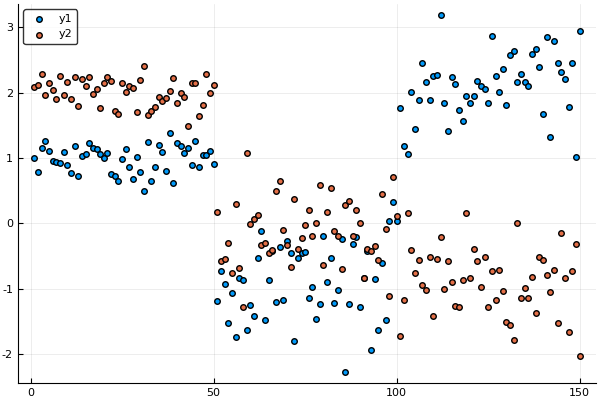

In [38]:
model = KMeans(5)
using Plots
points = vcat( randn(50,2)*0.2 .+ [1.0 2.0], randn(50,2)*0.5 .+ [-1.0 0.0], randn(50,2)*0.5 .+ [2.0 -1.0] )

scatter(points)

In [33]:
vcat(randn(50,2)*0.2 .+ [1.0 2.0], randn(50,2)*0.2 .+ [1.0 2.0])

100×2 Array{Float64,2}:
 1.01218   1.97301
 1.21049   2.03698
 1.23652   2.1481 
 1.1154    1.73253
 1.11719   2.02073
 1.27488   2.18354
 1.02382   2.21404
 1.12586   1.84664
 0.948509  1.97617
 1.05152   1.80049
 1.18676   2.09193
 1.28904   2.01353
 0.884006  2.0516 
 ⋮                
 1.02936   2.08447
 0.836537  2.30386
 0.903281  2.33309
 1.11648   2.27525
 0.977585  2.35686
 1.05292   2.00415
 1.06815   1.84419
 1.09951   1.95009
 1.11082   2.11132
 0.73388   1.70292
 0.583742  1.82661
 0.778028  1.87095

In [15]:
p = [1,2,4,2,3,1]
indeces = (p .== 2)
sum(indeces.==true)

2

### Making a helper strategy

Now it's quite hard to tell whether it's actually working any good given the optimizer is quite bad and will keep moving even when it reaches a maximum, therefore I'd like to be able to visualise.. 

Why not build a path tracing strategy!

In [8]:
# One array for each coordinate to keep track of positions
mutable struct PathTracer <: LearningStrategy
    x::Array{Float64}
    y::Array{Float64}
    z::Array{Float64}
end

# The constructor (for any argument) is simply to initialise the arrays
PathTracer() = PathTracer([],[],[])

# On setup, save initial position
function setup!(s::PathTracer, model::HillClimber)
   update!(model, s) 
end

# Save current position
function update!(model::HillClimber, s::PathTracer)
    push!(s.x, model.x)
    push!(s.y, model.y)
    push!(s.z, model.z)
end

update! (generic function with 6 methods)

In [9]:
# Run the model again, this time adding the path tracer strategy
model = HillClimber(2.0, -4.8, 0.0, heuristic)
tracer = PathTracer()
learn!(model, strategy(SillyOptimizer(), MaxIter(30), tracer) )

HillClimber(0.4190427665181933, 0.7809572334818065, 0.9616375377854732, heuristic)

In [ ]:
# Plot
using Plots
pyplot()
xs = linspace(-3,3,30)
ys = linspace(-5,5,30)
z = [heuristic([x, y]) for x=xs, y=ys]'

anim = @animate for max_length = 2:length(tracer.x)-1
    plot(xs, ys, z)
    for i in 1:max_length
        plot!([tracer.x[i], tracer.x[i+1]], [tracer.y[i], tracer.y[i+1]], arrow = true, color="black")
    end
    plot!(legend=false, cb=false, title="SillyOptimizer Trace")
end

![SillyOptimizer](resources/SillyOptimizer.gif)

That seems to work quite well!

### Hook Strategy

The `hook` method is another method allowed in the framework, which should mostly be using for printing or logging. Nevertheless, here is a small example of what could be done with it: showing the current iteration!

In [11]:
# Define the structure 
mutable struct Iteration <: LearningStrategy
    n::Int
end

# Make the constructor always initialise to iteration 0
Iteration() = Iteration(0)

# Simple function to make nice priting
Base.show(io::IO, s::Iteration) = print(io, "Iteration: $(s.n)")

# The main culprit
function hook(s::Iteration, model, .. )
    info(s)
    s.n+=1
end

# Note: this is a slight cheat, since hook shouldn't be modifying in place.. 
#       you'd usually want to update in update!(), and hook to record/show

hook (generic function with 7 methods)

Resulting in a quite horrible logging!

In [12]:
# Run the model again, this time adding the path tracer strategy
model = HillClimber(2.0, -4.8, 0.0, heuristic)
tracer = PathTracer()
learn!(model, Verbose(strategy(SillyOptimizer(), MaxIter(15), tracer, Iteration())) )

INFO: Iteration: 0
INFO: Iteration: 1
INFO: Iteration: 2
INFO: Iteration: 3
INFO: Iteration: 4
INFO: Iteration: 5
INFO: Iteration: 6
INFO: Iteration: 7
INFO: Iteration: 8
INFO: Iteration: 9
INFO: Iteration: 10
INFO: Iteration: 11
INFO: Iteration: 12
INFO: Iteration: 13
INFO: Iteration: 14
INFO: MaxIter(15) finished


HillClimber(-0.006653057455942357, 0.20665305745594265, 0.9488934144329644, heuristic)